Code Modified From: https://youtu.be/PuZY9q-aKLw

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

from preprocess import load_data

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import Callback

In [2]:
item = "SPONGE"

data_set = load_data()
data = data_set[item]

for i in range(0, len(data)):
    if data["buy_volume"][i] == 0 and data["sell_volume"][i] == 0:
        data = data.drop(i)

In [3]:
print(data.head())
print(data.shape)

            Date  sell_price  sell_volume  sell_moving_week  sell_orders  \
0  2024-02-14-23   42.406750    5747081.0         7480195.0        132.0   
1  2024-02-15-00   42.487058    5769887.0         7532305.0        133.0   
2  2024-02-15-01   42.736993    5831963.0         7580315.0        135.0   
3  2024-02-15-02   42.411493    5720894.0         7620649.0        133.0   
4  2024-02-15-03   42.315665    5657846.0         7683697.0        130.0   

   buy_price  buy_volume  buy_moving_week  buy_orders  max_sell_price  \
0  59.985276    332194.0         967014.0       100.0            42.5   
1  65.142329    322401.0         976807.0        98.0            42.6   
2  67.978409    312956.0         986083.0        94.0            42.8   
3  67.700000    321901.0         987142.0        92.0            42.6   
4  67.400000    330600.0         988292.0        99.0            42.4   

   min_buy_price  
0           59.8  
1           60.0  
2           65.1  
3           67.7  
4        

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data = scaler.fit_transform(data['sell_price'].values.reshape(-1, 1))
scaled_data = scaled_data.flatten()
print(scaled_data.shape)

(1267,)


In [5]:
prediction_hours = 48
train_test_split = 0.8

len_train = int(len(scaled_data) * train_test_split)  

x_train = []
y_train = []

x_test = [] 
y_test = []

for i in range(prediction_hours, len_train):
    x_train.append(scaled_data[i - prediction_hours:i])
    y_train.append(scaled_data[i]) 

for i in range(len_train, len(scaled_data)):
    x_test.append(scaled_data[i - prediction_hours:i])
    y_test.append(scaled_data[i])

x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape) 
print(y_test.shape)


(965, 48)
(965,)
(254, 48)
(254,)


In [6]:
class DetectOverfittingCallback(Callback):
    def __init__(self, threshold=0.7):
        super(DetectOverfittingCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        ratio = logs["val_loss"] / logs["loss"]
        print("Epoch: {}, Val/Train loss ratio: {:.2f}".format(epoch, ratio))

        if ratio > self.threshold:
            print("Stopping training...")
            self.model.stop_training = True

In [7]:
model = Sequential()

model.add(LSTM(units=40, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=40, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=40, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=40))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [8]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 40)            6720      
                                                                 
 dropout (Dropout)           (None, 48, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 48, 40)            12960     
                                                                 
 dropout_1 (Dropout)         (None, 48, 40)            0         
                                                                 
 lstm_2 (LSTM)               (None, 48, 40)            12960     
                                                                 
 dropout_2 (Dropout)         (None, 48, 40)            0         
                                                                 
 lstm_3 (LSTM)               (None, 40)                1

In [9]:
history = model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(x_test, y_test), callbacks=[DetectOverfittingCallback(threshold=2)])

Epoch 1/500
31/31 [==============================] - 10s 53ms/step - loss: 0.1212 - val_loss: 0.0022
Epoch 2/500
31/31 [==============================] - 1s 21ms/step - loss: 0.0280 - val_loss: 0.0058
Epoch 3/500
31/31 [==============================] - 1s 21ms/step - loss: 0.0238 - val_loss: 9.2606e-04
Epoch 4/500
31/31 [==============================] - 1s 20ms/step - loss: 0.0239 - val_loss: 0.0021
Epoch 5/500
31/31 [==============================] - 1s 21ms/step - loss: 0.0223 - val_loss: 0.0026
Epoch 6/500
31/31 [==============================] - 1s 21ms/step - loss: 0.0216 - val_loss: 0.0012
Epoch 7/500
31/31 [==============================] - 1s 21ms/step - loss: 0.0215 - val_loss: 0.0018
Epoch 8/500
31/31 [==============================] - 1s 21ms/step - loss: 0.0196 - val_loss: 0.0012
Epoch 9/500
31/31 [==============================] - 1s 21ms/step - loss: 0.0184 - val_loss: 0.0051
Epoch 10/500
31/31 [==============================] - 1s 21ms/step - loss: 0.0179 - val_loss: 0

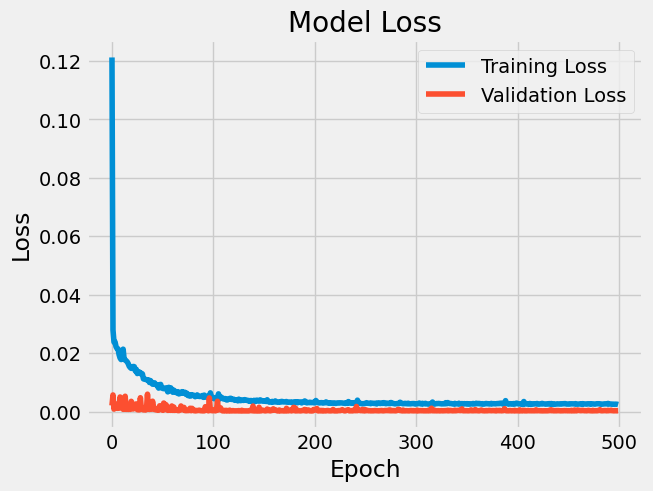

In [10]:
plt.style.use('fivethirtyeight')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
predicted = model.predict(x_test)
predicted = scaler.inverse_transform(predicted) 

y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

8/8 [==============================] - 1s 7ms/step


In [12]:
print(predicted.shape)
print(y_test.shape)

(254, 1)
(254, 1)


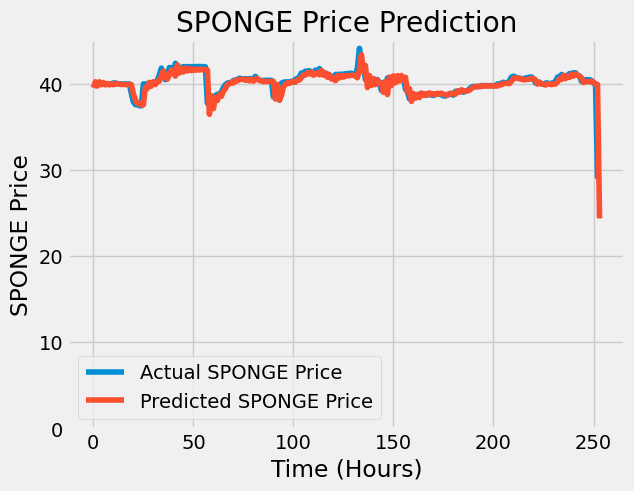

In [13]:
plt.style.use('fivethirtyeight')
plt.plot(y_test, label=f"Actual {item} Price")
plt.plot(predicted, label=f"Predicted {item} Price")
#y axis have minimum of 0 
plt.ylim(0)
plt.title(f"{item} Price Prediction")
plt.xlabel('Time (Hours)')
plt.ylabel(f"{item} Price")
plt.legend()
plt.show()


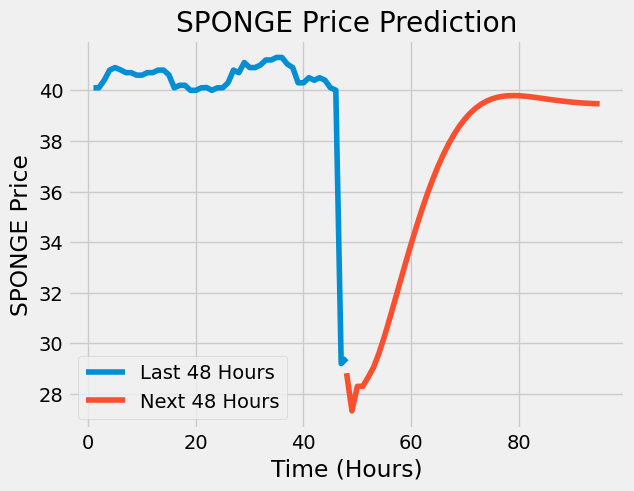

In [34]:
x_input = scaled_data[-prediction_hours:]
temp_input = list(x_input)

model_output = []

for i in range(48):  
    x_input = np.array(temp_input)
    x_input = x_input.reshape(1, -1)
    x_input = x_input.reshape((1, prediction_hours, 1))

    prediction = model.predict(x_input, verbose=0) 
    prediction = prediction.flatten() 

    temp_input.append(prediction[0])
    if len(temp_input) > prediction_hours:
        temp_input = temp_input[1:]
    model_output.append(prediction[0]) 



# plot the future 48 hours
day_new = np.arange(1, prediction_hours + 1)
day_pred = np.arange(prediction_hours, prediction_hours + 48)

prev_data = scaled_data[-prediction_hours:]
prev_data = prev_data.reshape(-1, 1)
prev_data = scaler.inverse_transform(prev_data) 

plt.plot(day_new, prev_data.flatten(), label="Last 48 Hours")
plt.plot(day_pred, scaler.inverse_transform(np.array(model_output).reshape(-1, 1)).flatten(), label="Next 48 Hours")
plt.title(f"{item} Price Prediction")
plt.xlabel("Time (Hours)")
plt.ylabel(f"{item} Price")
plt.legend()
plt.show()